#### 原始的fragment2vec
- 选择parallel，best model
- 查看碎片之间的相似性
- 查看双键、芳香性等抽象度更高的结构信息

In [2]:
# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import pairwise_distances

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True

In [3]:
def cal_distance(x, y, metric='euclidean'):
    if type(x) == pd.core.series.Series:
        x = x.values.reshape(1, -1)
    if type(y) == pd.core.series.Series:
        y = y.values.reshape(1, -1)
    return pairwise_distances(x, y, metric=metric)

In [60]:
def print_closest_words(x_embedding, x_query, n=5, add_vec=None):
    x = x_embedding.loc[x_query].values.reshape(1, -1).copy()
    # print('x is: {}'.format(x))
    if add_vec is not None:
        x += add_vec
        # print('x + add_vec is: {}'.format(x))
    dists = cal_distance(x=x_embedding.values, y=x)     # compute distances to all words
    lst = sorted(enumerate(dists), key=lambda x: x[1]) # sort by distance
    # print(lst[:100])
    all_smiles = []
    all_dis = [] 
    if add_vec is not None:
        for idx, difference in lst[0:n]:
            _smiles = x_embedding.iloc[idx,:].name
            all_smiles.append(_smiles)
            all_dis.append(difference[0])
            # print(_smiles, difference)
    else:
        for idx, difference in lst[1:n+1]:   # take the top n
            _smiles = x_embedding.iloc[idx,:].name
            all_smiles.append(_smiles)
            all_dis.append(difference[0])
            # print(_smiles, difference)
    all_dis = ['{:.2f}'.format(i) for i in all_dis]
    return {'smiles': all_smiles, 'dis': all_dis}

In [5]:
def get_minus_result(x_embedding, x, y):
    x = x_embedding.loc[x].values.reshape(1, -1)
    y = x_embedding.loc[y].values.reshape(1, -1)
    return x-y

In [6]:
def draw_mol_by_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    size = (200, 200)
    return Draw.MolToImage(mol, size=size)

In [7]:
def draw_multiple_mol(smiles_list, mols_per_row=4, file_path=None, legends=None):
    mols = []
    for i in smiles_list:
        mols.append(Chem.MolFromSmiles(i))
    mols_per_row = min(len(smiles_list), mols_per_row)
    if legends is None:
        img=Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(220, 120), useSVG=True)
    else:
        img=Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(220, 120), useSVG=True, legends=legends)
    if file_path:
        with open(file_path, 'w') as f_handle:
            f_handle.write(img.data)
    return img

In [8]:
frag2vec = pd.read_csv('./model_parallel/frag2vec_ws_4_minn_1_maxn_2.csv', index_col=0)
frag2vec.head(2)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
fragment,,,,,,,,,,,,,,,,,,,,,
CC,0.102366,0.236778,-0.212418,0.097849,0.353949,0.066136,0.251520,0.141767,-0.135168,0.230127,...,0.707791,-0.000694,-0.055997,0.399240,-0.149455,0.417486,0.369599,-0.189464,-0.133221,0.059110
CN,0.135850,0.226165,-0.434924,0.303119,-0.014223,0.132242,0.368385,0.068198,-0.059371,0.287510,...,0.617289,-0.113810,0.043899,0.385367,0.093859,0.156435,0.381115,-0.142981,0.027194,-0.063204


In [3]:
frag2vec.shape

(505, 100)

In [54]:
# demo_frags = np.random.choice(frag2vec.index.to_list(), 5, replace=False)
demo_frags = ['C1=CCNN=C1', 'C1=COCO1', 'C1=CCC1', 'C1=CN=N[SH]=C1', 'OBr']
demo_frags

['C1=CCNN=C1', 'C1=COCO1', 'C1=CCC1', 'C1=CN=N[SH]=C1', 'OBr']

In [55]:
frag2nn = {}
for frag in demo_frags:
    frag2nn[frag] = print_closest_words(x_embedding=frag2vec, x_query=frag, n=7)

In [56]:
nn1 = frag2nn['C1=COCO1']
nn1

{'smiles': ['C1=COCCO1',
  'C1=COCCCO1',
  'C1=CO1',
  'C1=COCOC1',
  'C1=COCCOC1',
  'C1=CCOCOC1',
  'C1=NCCCO1'],
 'dis': [1.3378840407327308,
  1.9484125075791836,
  2.2607932819501433,
  2.4655408884687557,
  2.5521667090063422,
  2.586532753857119,
  2.670682410744231]}

In [57]:
for k, frag in enumerate(demo_frags):
    nn = frag2nn[frag]
    draw_multiple_mol(smiles_list=[frag] + nn['smiles'],  
                   legends=[frag] + [nn['smiles'][i] + '(' + str('{:.2f}'.format(nn['dis'][i])) + ')' for i in range(7)],
                   file_path='./images/original_frag_nn_{}.svg'.format(k))

#### test double bond

In [88]:
double_bond1 = get_minus_result(x_embedding=frag2vec, x='C=O', y='CO')
# double_bond

In [121]:
double_bond2 = get_minus_result(x_embedding=frag2vec, x='C=S', y='CS')

In [117]:
double_bond3 = get_minus_result(x_embedding=frag2vec, x='C1=CC1', y='C1CC1')

In [91]:
double_bond_mean = (double_bond1 + double_bond2 + double_bond3) / 3
double_bond_mean

array([[-0.14945666, -0.65290908, -0.06774845,  0.16166727, -0.34890804,
         0.15314207, -0.30461119,  0.14180235,  0.0297349 , -0.00582635,
         0.29550314,  0.48070542, -0.1088107 ,  0.50401956, -0.37556495,
        -0.06390181,  0.0240688 , -0.42016558, -0.49495385,  0.43652495,
         0.20046249, -0.59765469,  0.25913921,  0.1317017 ,  0.2405106 ,
        -0.02291437,  0.41487718, -0.24328594,  0.00288473,  0.8741334 ,
        -0.50964785,  0.5129253 ,  0.28116003,  0.26077457, -0.80906435,
         0.22428083, -0.30332953, -0.30646264, -0.05291128,  0.45888388,
         0.23161915, -0.2072919 , -0.42175025, -0.39103916,  0.49293456,
        -0.11727112, -0.16746569,  0.57061534,  0.16207857,  0.91136486,
        -0.06696406,  0.29005963,  0.30517925, -0.4537069 ,  0.36814029,
        -0.75110619,  0.25878434, -0.15745794,  0.30072877,  0.33531027,
        -0.3170505 , -0.51450093, -0.03248497, -0.36467736,  0.34476221,
        -0.16804982, -0.45931964, -0.14597341,  0.0

In [129]:
single_bond_frag = ['CO', 'CC', 'CN', 'CS', 'OS', 'C1CC1']
single_bond2nn = {}
for frag in single_bond_frag:
    single_bond2nn[frag] = print_closest_words(x_embedding=frag2vec, x_query=frag, n=5, add_vec=double_bond2)

In [130]:
cal_distance(frag2vec.loc['CN'].values + double_bond_mean, frag2vec.loc['C=N'])

array([[6.32302434]])

In [131]:
for frag in single_bond_frag:
    print('>> {} <<'.format(frag))
    print(single_bond2nn[frag])

>> CO <<
{'smiles': ['CO', 'C=O', 'C1=CC=COC=C1', 'C1=COCC=N1', 'C1=CC=CCC=C1'], 'dis': ['5.00', '5.39', '5.42', '5.52', '5.54']}
>> CC <<
{'smiles': ['C1CCCCCC1', 'C1=CC=CCC=C1', 'C=O', 'C1=CCC=NC=C1', 'CC'], 'dis': ['4.85', '4.88', '4.97', '5.00', '5.00']}
>> CN <<
{'smiles': ['CN', 'C=O', 'C1=CCC=NC=C1', 'C1CCCCCC1', 'C1=CC=CCC=C1'], 'dis': ['5.00', '5.04', '5.22', '5.23', '5.26']}
>> CS <<
{'smiles': ['C=S', 'C1C[SH]=NS1', 'NS', 'O=S', 'CS'], 'dis': ['0.00', '4.26', '4.33', '4.38', '5.00']}
>> OS <<
{'smiles': ['OS', 'O=S', 'NS', 'C=S', 'C1C[SH]=NS1'], 'dis': ['5.00', '6.73', '7.26', '7.54', '8.40']}
>> C1CC1 <<
{'smiles': ['C1CCCCCC1', 'C1CCCC1', 'C1CCC1', 'C1CC1', 'C1CCCCC1'], 'dis': ['4.89', '4.90', '4.98', '5.00', '5.03']}


In [132]:
print_closest_words(x_embedding=frag2vec, x_query='CO', n=5)

{'smiles': ['C1=COCC=N1',
  'C1=CCCOC=C1',
  'C1=CCOC=CC1',
  'C1=CCOCOC1',
  'C1=COCCOC1'],
 'dis': ['2.88', '2.90', '2.90', '2.95', '2.96']}

In [133]:
print_closest_words(x_embedding=frag2vec, x_query='OS', n=5)

{'smiles': ['O=S', 'NS', 'C1COSCSO1', 'OBr', 'CS'],
 'dis': ['6.38', '6.54', '7.40', '7.49', '7.54']}

#### test triple bond

In [65]:
tri_bond = get_minus_result(x_embedding=frag2vec, x='C#C', y='CC')

In [83]:
cn_add_tri_bond_nn = print_closest_words(x_embedding=frag2vec, x_query='CN', add_vec=tri_bond)
cn_add_tri_bond_nn

{'smiles': ['C#C', 'C1=CON=C1', 'C#N', 'CN', 'C1COC1'],
 'dis': [2.0746646357384675,
  3.851598374765036,
  4.171327245422764,
  4.2089828415025385,
  4.2588016118418235]}

In [84]:
print_closest_words(x_embedding=frag2vec, x_query='CN')

{'smiles': ['CC', 'C1=COC=C1', 'C1COCCO1', 'C1CCOC1', 'C1=CCC=NC=C1'],
 'dis': [2.0746646357384684,
  2.5587250731641857,
  2.558931641309026,
  2.5946924444424466,
  2.5966570193977443]}

#### test aromaticity（芳香性）

In [85]:
arom = get_minus_result(x_embedding=frag2vec, x='C1=CC=CC=C1', y='C1CCCCC1')

In [87]:
print_closest_words(x_embedding=frag2vec, x_query='C1CCCC1')

{'smiles': ['C1CCCCC1', 'C1CCCCCC1', 'C1CCOCC1', 'C1=CCCC=CC1', 'C1CCCOCC1'],
 'dis': [1.5055548090861803,
  1.7683505233222776,
  2.0486014449126917,
  2.1874284871082814,
  2.189285527644637]}

In [86]:
print_closest_words(x_embedding=frag2vec, x_query='C1CCCC1', add_vec=arom)

{'smiles': ['C1=CC=CC=C1',
  'C1=CC=COC=C1',
  'C1=CC=CNC=C1',
  'C1=CCC=NC=C1',
  'C1=CC=NC=C1'],
 'dis': [1.5055548090861814,
  2.4786185001017365,
  2.502898718438676,
  2.5621038970574874,
  2.6199867159118995]}

In [93]:
print_closest_words(x_embedding=frag2vec, x_query='C1CCNC1')

{'smiles': ['C1CCNCC1', 'C1COCCN1', 'C1CNCCN1', 'C1CCNCNC1', 'C1CCOCNC1'],
 'dis': [1.6443838646540268,
  2.170819843259323,
  2.2132769893673925,
  2.2540547833444777,
  2.2761720717561515]}

In [92]:
print_closest_words(x_embedding=frag2vec, x_query='C1CCNC1', add_vec=arom)

{'smiles': ['C1=CC=CC=C1',
  'C1CCNC1',
  'C1=CC=CNC=C1',
  'C1=CNC=CNC1',
  'C1=CC=COC=C1'],
 'dis': [2.7806917290748765,
  3.0839756828459097,
  3.110060697950161,
  3.3052409571906343,
  3.3485461076081036]}

#### test N atom

In [88]:
n = get_minus_result(x_embedding=frag2vec, x='C1CNC1', y='C1CC1')

In [90]:
print_closest_words(x_embedding=frag2vec, x_query='C1CCCC1')

{'smiles': ['C1CCCCC1', 'C1CCCCCC1', 'C1CCOCC1', 'C1=CCCC=CC1', 'C1CCCOCC1'],
 'dis': [1.5055548090861803,
  1.7683505233222776,
  2.0486014449126917,
  2.1874284871082814,
  2.189285527644637]}

In [91]:
print_closest_words(x_embedding=frag2vec, x_query='C1CCCC1', add_vec=n)

{'smiles': ['C1CNC1', 'C1CNCCOC1', 'C1CCNCC1', 'C1CCOCC1', 'C1CC2CC1CN2'],
 'dis': [2.2564268258018467,
  3.8010950538268298,
  3.861273343279964,
  3.9531810164869623,
  3.9651659706769586]}

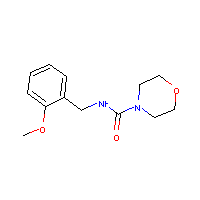

In [52]:
draw_mol_by_smiles('COc1ccccc1CNC(=O)N1CCOCC1')